In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import copy
import time
import matplotlib.pyplot as plt
from MLib.Core.metrics import MAPE

In [2]:
# Load the CDC prdictions from a pickle file
cdc_predictions = pickle.load(open('./CDC_predictions_Cases_Neurips.pkl', 'rb'))
SIMLR_results = pickle.load(open('./US_results.pkl', 'rb'))

In [3]:
# Set the starting and ending dates
start_dates = ['2020-07-05', '2020-07-12',\
               '2020-07-19', '2020-07-26', '2020-08-02', '2020-08-09',\
               '2020-08-16', '2020-08-23', '2020-08-30', '2020-09-06',\
               '2020-09-13', '2020-09-20', '2020-09-27', '2020-10-04',\
               '2020-10-11', '2020-10-18', '2020-10-25', '2020-11-01',\
               '2020-11-08', '2020-11-15', '2020-11-22', '2020-11-29',\
               '2020-12-06', '2020-12-13', '2020-12-20', '2020-12-27',\
               '2021-01-03', '2021-01-10', '2021-01-17', '2021-01-24',\
               '2021-01-31', '2021-02-07', '2021-02-14', '2021-02-21',\
               '2021-02-28', '2021-03-07', '2021-03-14', '2021-03-21',\
               '2021-03-28', '2021-04-04', '2021-04-11', '2021-04-18'\
              ]


end_dates = ['2020-07-11', '2020-07-18',\
             '2020-07-25', '2020-08-01', '2020-08-08', '2020-08-15',\
             '2020-08-22', '2020-08-29', '2020-09-05', '2020-09-12',\
             '2020-09-19', '2020-09-26', '2020-10-03', '2020-10-10',\
             '2020-10-17', '2020-10-24', '2020-10-31', '2020-11-07',\
             '2020-11-14', '2020-11-21', '2020-11-28', '2020-12-05',\
             '2020-12-12', '2020-12-19', '2020-12-26', '2021-01-02',\
             '2021-01-09', '2021-01-16', '2021-01-23', '2021-01-30',\
             '2021-02-06', '2021-02-13', '2021-02-20', '2021-02-27',\
             '2021-03-06', '2021-03-13', '2021-03-20', '2021-03-27',\
             '2021-04-03', '2021-04-10', '2021-04-17', '2021-04-24'\
            ]

dates_to_index = dict()

for i, date in enumerate(end_dates):
    dates_to_index[date] = i

In [4]:
# Load the real data
ground_truth_path = './covid19-forecast-hub/data-truth/truth-Incident Cases.csv'
ground_truth_dataframe = pd.read_csv(ground_truth_path)
# Get the us data only
us_flag = ground_truth_dataframe['location_name'] == 'US'
gt_us_dataframe = ground_truth_dataframe[us_flag]
gt_us_dataframe = gt_us_dataframe.reset_index()

# Get the ground truth data
ground_truth = -1*np.ones(len(dates_to_index))
gt_values = gt_us_dataframe['value'].values

for i, end_date in enumerate(end_dates):
    day_flag = gt_us_dataframe['date'] == end_date

    # Get the row numbers of the data of interest
    end_index = 1 + gt_us_dataframe[day_flag].index.values[0]
    start_index = end_index - 7
    ground_truth[i] = np.sum(gt_values[start_index:end_index])

/home/rvega/Envs/neurips/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


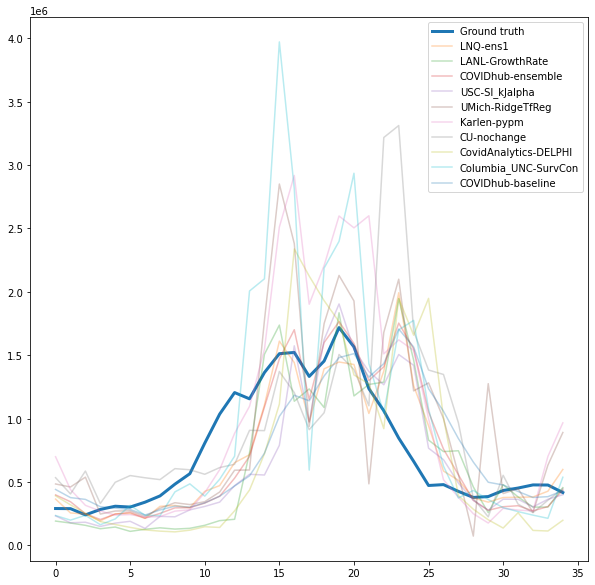

In [5]:
weeks=4
last_entries = -35
legend_text = ['Ground truth']

plt.figure(figsize=(10,10))
plt.plot(ground_truth[last_entries:], linewidth=3)

for model in cdc_predictions[str(weeks) + ' weeks ahead']:
    c_predictions = cdc_predictions[str(weeks) + ' weeks ahead'][model]
    
    if np.sum(c_predictions[last_entries:]==-1) == 0:
        plt.plot(c_predictions[last_entries:], alpha=0.3)
        legend_text.append(model)

plt.legend(legend_text)
plt.show()

In [6]:
# Compute the MAPE 1, 2, 3, and 4 weeks ahead
MAPE_dict = dict()
std_dict = dict()

for i in range(4):
    
    for model in cdc_predictions[str(i+1) + ' weeks ahead']:
        c_predictions = cdc_predictions[str(i+1) + ' weeks ahead'][model]
    
        if np.sum(c_predictions[last_entries:]==-1) == 0:
            if model not in MAPE_dict:
                MAPE_dict[model] = -1*np.ones(4)
                std_dict[model] = -1*np.ones(4)

for i in range(4):
    for model in cdc_predictions[str(i+1) + ' weeks ahead']:
        c_predictions = cdc_predictions[str(i+1) + ' weeks ahead'][model]
    
        if np.sum(c_predictions[last_entries:]==-1) == 0:
            c_mape, c_std = MAPE(ground_truth[last_entries:], 
                                 c_predictions[last_entries:], 
                                 np.mean)
            
            MAPE_dict[model][i] = c_mape
            std_dict[model][i] = c_std

for model in MAPE_dict:
    nan_flag = MAPE_dict[model] == -1
    MAPE_dict[model][nan_flag] = np.nan
    std_dict[model][nan_flag] = np.nan

['CovidAnalytics-DELPHI' 'UMich-RidgeTfReg' 'IowaStateLW-STEM'
 'CU-scenario_low' 'CU-nochange' 'CU-select' 'LANL-GrowthRate'
 'CU-scenario_mid' 'CU-scenario_high' 'CEID-Walk' 'Columbia_UNC-SurvCon'
 'OliverWyman-Navigator' 'COVIDhub-baseline' 'Karlen-pypm'
 'USC-SI_kJalpha' 'COVIDhub-ensemble' 'Geneva-DetGrowth' 'LNQ-ens1']


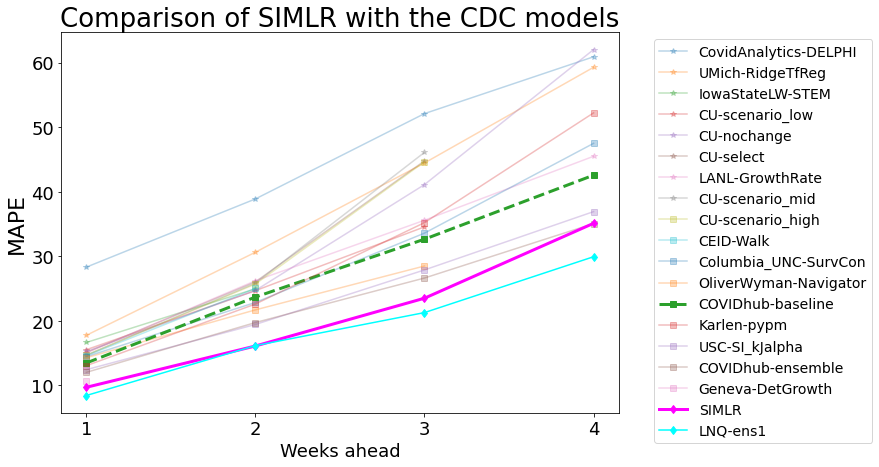

In [7]:
# Get the MAPE of the first week for every model
mape_week_1 = list()
names_week_1 = list()

for model in MAPE_dict:
    mape_week_1.append(MAPE_dict[model][0])
    names_week_1.append(model)

mape_week_1 = np.array(mape_week_1)
names_week_1 = np.array(names_week_1)

# Rank the model from highest to lowest MAPE
order = np.flip(np.argsort(mape_week_1))
print(names_week_1[order])

plt.figure(figsize=(10,7))
text_legend = list()

markers_list = ['*', 's', 'd']
marker_index = 0
marker_counter = 0

for model in names_week_1[order[:-1]]:
    if model == 'COVIDhub-baseline':
        plt.plot(MAPE_dict[model], '--', linewidth=3, marker=markers_list[marker_index])
        text_legend.append(model)
    else:
        plt.plot(MAPE_dict[model], alpha=0.3, marker=markers_list[marker_index])
        text_legend.append(model)
        marker_counter +=1
    
    if marker_counter > 7:
        marker_counter = 0
        marker_index +=1

plt.plot([9.7, 16.1, 23.5, 35.1], linewidth=3, color='magenta', marker='d')
text_legend.append('SIMLR')

model = 'LNQ-ens1'
plt.plot(np.arange(4), MAPE_dict[model], color='cyan', marker='d')
text_legend.append(model)
plt.title('Comparison of SIMLR with the CDC models', fontsize=26)
plt.legend(text_legend,  fontsize=14, bbox_to_anchor=(1.05, 1),)
plt.yticks(fontsize=18)
plt.xticks(np.arange(4), [1,2,3,4],fontsize=18)

plt.ylabel('MAPE', fontsize=22)
plt.xlabel('Weeks ahead', fontsize=18)
plt.savefig('CDC_comparison.png', dpi=400, bbox_inches='tight', 
            transparent=False, facecolor='white')

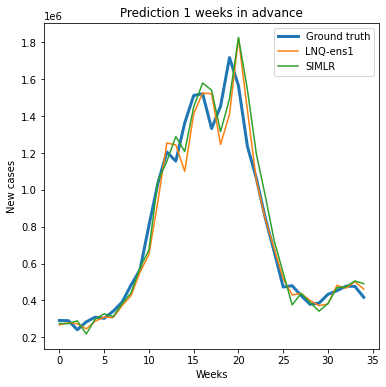

In [8]:
weeks=1
last_entries = -35
legend_text = ['Ground truth']

plt.figure(figsize=(6,6))
plt.plot(ground_truth[last_entries:], linewidth=3)

c_predictions = cdc_predictions[str(weeks) + ' weeks ahead']['LNQ-ens1'][last_entries:]

start_week= 4-weeks
end_week = -1 * (weeks)
simlr = SIMLR_results['United States']['Mixed_Cases_W_'+str(weeks)][start_week:end_week]


plt.plot(c_predictions)
legend_text.append('LNQ-ens1')

plt.plot(simlr)
legend_text.append('SIMLR')

plt.legend(legend_text)

plt.xlabel('Weeks')
plt.ylabel('New cases')
plt.title('Prediction ' + str(weeks) + ' weeks in advance')
plt.show()